In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Class 14: Prescott's Real Business Cycle Model I

In this notebook, we'll consider a centralized version of the model from pages 11-17 in Edward Prescott's article "Theory Ahead of Business Cycle Measurement in the Fall 1986 of the Federal Reserve Bank of Minneapolis' *Quarterly Review* (link to article: https://www.minneapolisfed.org/research/qr/qr1042.pdf). The model is just like the RBC model that we studying in the previous lecture, except that now we include an endogenous labor supply.

## Prescott's RBC Model with Labor

The equilibrium conditions for Prescott's RBC model with labor are:

\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right]\\
\frac{\varphi}{1-L_t} & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} \\
Y_t & = A_t K_t^{\alpha}L_t^{1-\alpha}\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The objective is use `linearsolve` to simulate impulse responses to a TFP shock using the following parameter values for the simulation:

| $$\rho$$ | $$\sigma$$ | $$\beta$$ | $$\varphi$$ | $$\alpha$$ | $$\delta $$ |
|----------|------------|-------------|-----------|------------|-------------|
| 0.75     | 0.006      | 0.99      | 1.7317      | 0.35       |  0.025      |


The value for $\beta$ implies a steady state (annualized) real interest rate of about 4 percent: 
    
\begin{align}
4 \cdot \left(\beta^{-1} - 1\right)  & \approx 0.04040
\end{align}

$\rho = 0.75$ and $\sigma = 0.006$ are consistent with the statistical properties of the cyclical component of TFP in the US. $\alpha$ is set so that, consistent with the long-run average of the US, the labor share of income is about 65 percent of GDP. The deprecation rate of capital is calibrated to be about 10 percent annually. Finally, $\varphi$ was chosen last to ensure that in the steady state households allocate about 33 percent of their available time to labor.

## Model Preparation

Before proceding, let's recast the model in the form required for `linearsolve`. Write the model with all variables moved to the left-hand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:

\begin{align}
0 & = \beta\left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right] - \frac{1}{C_t}\\
0 & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} - \frac{\varphi}{1-L_t}\\
0 & = A_t K_t^{\alpha}L_t^{1-\alpha} - Y_t\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = C_t + I_t - Y_t\\
0 & = \rho \log A_t - \log A_{t+1}
\end{align}

Remember, capital and TFP are called *state variables* because they're $t+1$ values are predetermined. Output, consumption, and investment are called a *costate* or *control* variables. Note that the model as 5 equations in 5 endogenous variables.



## Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['rho'] = .75
parameters['beta'] = 0.99
parameters['phi'] = 1.7317
parameters['alpha'] = 0.35
parameters['delta'] = 0.025

# Print the model's parameters
print(parameters)

rho      0.7500
beta     0.9900
phi      1.7317
alpha    0.3500
delta    0.0250
dtype: float64


In [3]:
# Create a variable called 'sigma' that stores the value of sigma
sigma = 0.006

In [4]:
# Create variable called 'var_names' that stores the variable names in a list with exogenous state variables
# ordered first, endogenous state variables ordered second, and control variables ordered last.
var_names = ['a','k','y','c','i','l']

# Create variable called 'shock_names' that stores an exogenous shock name for each exogenous state variable.
shock_names = ['e_a']

In [5]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward
    
    # Define variable to store MPK(t+1). Will make things easier later.
    mpk = p.alpha*fwd.a*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha)
    
    # Define variable to store MPL(t). Will make things easier later.
    mpl = (1-p.alpha)*cur.a*cur.k**p.alpha*cur.l**-p.alpha

    # Euler equation
    euler_equation = p.beta*(mpk+1-p.delta)/fwd.c - 1/cur.c
    
    # Labor-leisure choice
    labor_leisure = mpl/cur.c - p.phi/(1-cur.l)
    
    # Production function
    production_function = cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) - cur.y
    
    # Capital evolution. PROVIDED
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    # Market clearing. PROVIDED
    market_clearing = cur.c+cur.i - cur.y
    
    # Exogenous tfp. PROVIDED
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        labor_leisure,
        production_function,
        capital_evolution,
        market_clearing,
        tfp_process
        ])

Next, initialize the model using `ls.model` which takes the following required arguments:

* `equations`
* `n_states`
* `var_names`
* `shock_names`
* `parameters`

In [6]:
# Initialize the model into a variable named 'rbc_model'
rbc_model = ls.model(equations = equilibrium_equations,
                     n_states=2,
                     n_exo_states=1,
                     var_names=var_names,
                     shock_names=shock_names,
                     parameters=parameters)

In [7]:
# Compute the steady state numerically using .compute_ss() method of rbc_model
guess = [1,4,1,1,1,0.5]
rbc_model.compute_ss(guess)

# Print the computed steady state
print(rbc_model.ss)

a     1.000000
k    11.465953
y     1.149904
c     0.863256
i     0.286649
l     0.333330
dtype: float64


In [8]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of rbc_model
rbc_model.approximate_and_solve()

## Impulse Responses

Compute a 26 period impulse responses of the model's variables to a 0.01 unit shock to TFP in period 5.

In [9]:
# Compute impulse responses
rbc_model.impulse(T=26,t0=5,shocks=[0.01])

# Print the first 10 rows of the computed impulse responses to the TFP shock
print(rbc_model.irs['e_a'].head(10))

    e_a         a         k         y         c         i         l
0  0.00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
2  0.00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
3  0.00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
4  0.00  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
5  0.01  0.010000  0.000000  0.016262  0.001812  0.059778  0.009633
6  0.00  0.007500  0.001494  0.012481  0.002194  0.043462  0.006858
7  0.00  0.005625  0.002544  0.009632  0.002440  0.031290  0.004795
8  0.00  0.004219  0.003262  0.007482  0.002587  0.022224  0.003264
9  0.00  0.003164  0.003736  0.005857  0.002660  0.015485  0.002131


Construct a $2\times3$ grid of plots of simulated TFP, output, labor, consumption, investment, and capital. Be sure to multiply simulated values by 100 so that vertical axis units are in "percent deviation from steady state."

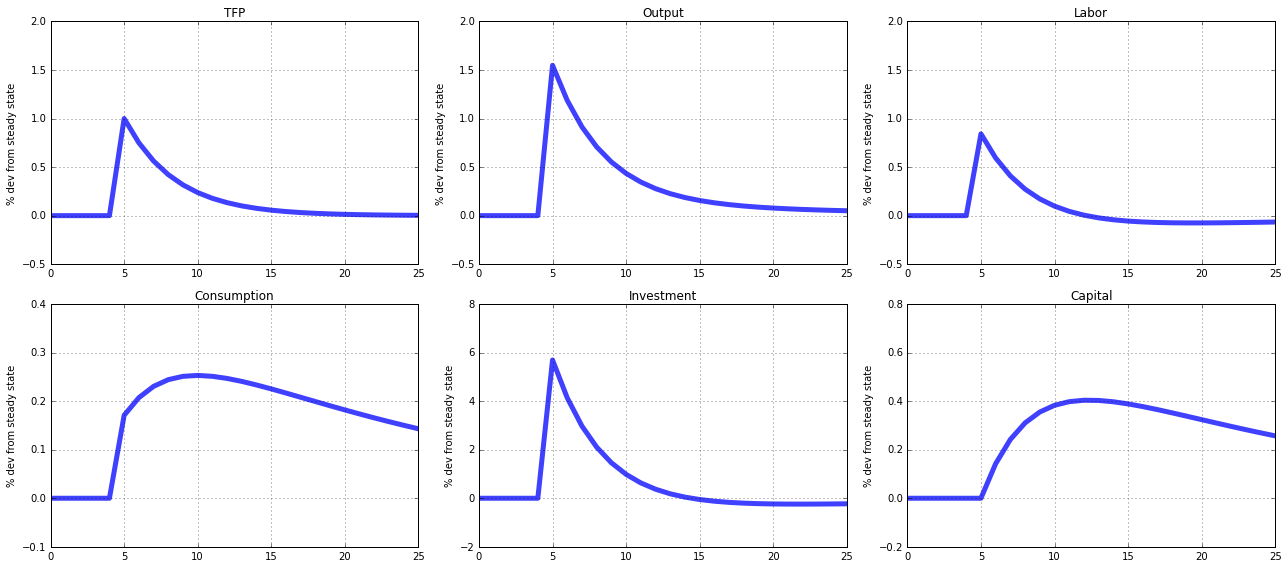

In [10]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(18,8))

# Create upper-left axis. PROVIDED
ax1 = fig.add_subplot(2,3,1)
# Create upper-center axis. PROVIDED
ax2 = fig.add_subplot(2,3,2)
# Create upper-right axis. PROVIDED
ax3 = fig.add_subplot(2,3,3)
# Create lower-left axis. PROVIDED
ax4 = fig.add_subplot(2,3,4)
# Create lower-center axis. PROVIDED
ax5 = fig.add_subplot(2,3,5)
# Create lower-right axis. PROVIDED
ax6 = fig.add_subplot(2,3,6)

# Set axis 1 ylabel. PROVIDED
ax1.set_ylabel('% dev from steady state')
# Set axis 2 ylabel. PROVIDED
ax2.set_ylabel('% dev from steady state')
# Set axis 3 ylabel. PROVIDED
ax3.set_ylabel('% dev from steady state')
# Set axis 4 ylabel. PROVIDED
ax4.set_ylabel('% dev from steady state')
# Set axis 5 ylabel. PROVIDED
ax5.set_ylabel('% dev from steady state')
# Set axis 6 ylabel. PROVIDED
ax6.set_ylabel('% dev from steady state')

# Set axis 1 limits. PROVIDED
ax1.set_ylim([-0.5,2])
# Set axis 2 limits. PROVIDED
ax2.set_ylim([-0.5,2])
# Set axis 3 limits. PROVIDED
ax3.set_ylim([-0.5,2])
# Set axis 4 limits. PROVIDED
ax4.set_ylim([-0.1,0.4])
# Set axis 5 limits. PROVIDED
ax5.set_ylim([-2,8])
# Set axis 6 limits. PROVIDED
ax6.set_ylim([-0.2,0.8])

# Plot TFP on axis 1
(rbc_model.irs['e_a']['a']*100).plot(ax=ax1,title='TFP',lw=5,alpha=0.75,grid=True)

# Plot output on axis 2
(rbc_model.irs['e_a']['y']*100).plot(ax=ax2,title='Output',lw=5,alpha=0.75,grid=True)

# Plot labor on axis 3
(rbc_model.irs['e_a']['l']*100).plot(ax=ax3,title='Labor',lw=5,alpha=0.75,grid=True)

# Plot consumption on axis 4
(rbc_model.irs['e_a']['c']*100).plot(ax=ax4,title='Consumption',lw=5,alpha=0.75,grid=True)

# Plot investment on axis 5
(rbc_model.irs['e_a']['i']*100).plot(ax=ax5,title='Investment',lw=5,alpha=0.75,grid=True)

# Plot capital on axis 6
(rbc_model.irs['e_a']['k']*100).plot(ax=ax6,title='Capital',lw=5,alpha=0.75,grid=True)

# Manage whitespace
fig.tight_layout()